In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline

/u/home/hliastro/yt-x86_64/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

## remove lines from failed global timesteps

In [3]:
import subprocess
output = subprocess.check_output(["grep -nr 'done with \| restart' std.new"], shell=True)

In [4]:
temp = output.split('\n')
start = 0
end = 0
line_range = []
for i in temp:
    if 'done with' in i:
        end = int(i.split(':')[0])
        line_range.append([start, end])
        start = int(i.split(':')[0])
    elif 'restart' in i:
        start = int(i.split(':')[0])

In [5]:
def select_lines(data, ranges):
    d = []
    for r in ranges:
        d.extend( data[r[0]:r[1]] )
    return d

In [6]:
inp = open('std.new').readlines()

In [7]:
inp = select_lines(inp, line_range)

## get data from lines with 'Hui'

In [8]:
data = np.zeros([len(inp), 9])
for i in range(len(inp)):
    l = inp[i]
    if 'Hui' in l:
        if 'id' in l:
            t = l.split('=')
            data[i,0] = float(t[1].split(',')[0])
            data[i,1] = float(t[2].split(',')[0])
            data[i,2] = float(t[3].split(',')[0])
            data[i,3] = float(t[4].split(',')[0])
            data[i,4] = float(t[5].split(',')[0])
            data[i,5] = float(t[6].split(',')[0])
            data[i,6] = float(t[7].split(',')[0])
            data[i,7] = float(t[8].split(',')[0])
            data[i,8] = float(t[9].split(',')[0])
#             d1 = int(t[1].split(',')[0])
#             d2 = float(t[2].split(',')[0])
#             d3 = float(t[3].split(',')[0])
#             d4 = float(t[4].split(',')[0])
#             data.append([d1,d2,d3,d4])

## get cluster particle list

In [9]:
data = data[data[:,0]!=0]
id_list = np.unique(data[:,0])

In [10]:
data_sorted = []
for id in id_list:
    data_sorted.append(data[data[:,0]==id])

## select those whose mass and age are in reasonable range

In [11]:
plt.style.use('niceplot')

In [12]:
mass_temp = []
for d in data_sorted:
    if np.max(d[:,5])<14.5:
        continue
    if np.min(d[:,5])>0.03:
        continue
    mass_temp.append(d[:,3][-1])

In [13]:
np.max(mass_temp)

602991.74696799996

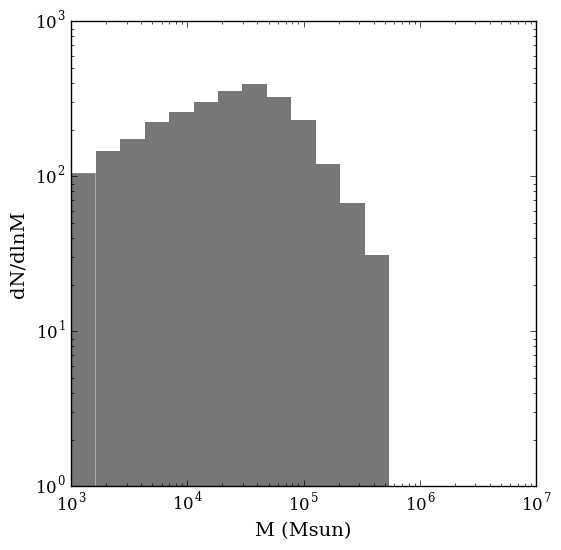

In [14]:
plt.hist(mass_temp, np.logspace(3,7,20))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('M (Msun)')
plt.ylabel('dN/dlnM')
plt.ylim(1,1e3)
plt.savefig('CIMF_no_mol.png')

## load simulation snapshots

In [16]:
import yt
from yt import derived_field
from yt.units.yt_array import YTQuantity
from yt import YTArray
from yt.utilities.physical_constants import kboltz, mp, G
data_ds = yt.load('./OUT/continuous_stop.art')
#halo_ds = np.loadtxt('./OUT/continuous_a0.1401_halo_info.dat')

yt : [WARNING  ] 2017-04-07 13:31:00,936 DeltaDC != 0, which implies auni != abox.  Be sure you understand which expansion parameter is appropriate for your use! (Gnedin, Kravtsov, & Rudd 2011)
yt : [INFO     ] 2017-04-07 13:31:00,956 Parameters: current_time              = 917801134.991 yr
yt : [INFO     ] 2017-04-07 13:31:00,957 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2017-04-07 13:31:00,958 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-04-07 13:31:00,959 Parameters: domain_right_edge         = [ 128.  128.  128.]
yt : [INFO     ] 2017-04-07 13:31:00,961 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2017-04-07 13:31:00,962 Parameters: current_redshift          = 6.08058618021
yt : [INFO     ] 2017-04-07 13:31:00,962 Parameters: omega_lambda              = 0.696400016546
yt : [INFO     ] 2017-04-07 13:31:00,963 Parameters: omega_matter              = 0.303599983454
yt : [INFO     ] 2017-04-07 13:31:00,964 Par

In [17]:
ad = data_ds.all_data()

In [78]:
ft = ad['STAR', 'creation_time'].in_units('Myr')
age = ad['STAR', 'age'].in_units('Myr')
mass = ad['STAR', 'initial_mass'].in_units('Msun')
tau_ave_orig = ad['STAR', 'AVERAGE_AGE']
age_spread_orig = ad['STAR', 'AGE_SPREAD']
pid = (ad['STAR','PID'].value).astype('int')

In [19]:
def sf_duration(data, region):
    # calculate the cluster formation duration in unit of Myrs
    # t_termination - t_birth
    return YTArray(data._handle.tphys_from_tcode_array(region[("STAR", "TERMINATION_TIME")])/1e6, "Myr") - region[("STAR", "creation_time")].in_units("Myr")
def sf_ave_time(data, region):
    # calculate the average cluster formation time in unit of Myrs
    return YTArray(data._handle.tphys_from_tcode_array(region[("STAR", "AVERAGE_AGE")]+region[("STAR", "BIRTH_TIME")])/1e6, "Myr") - region[("STAR", "creation_time")].in_units("Myr")
def sf_age_spread(data, region):
    # calculate the average cluster formation time in unit of Myrs
    return YTArray(data._handle.tphys_from_tcode_array(region[("STAR","initial_mass")]*region[("STAR","initial_mass")]/region[("STAR", "AGE_SPREAD")]/data.arr(1, 'code_mass**2')+region[("STAR", "BIRTH_TIME")])/1e6, "Myr") - region[("STAR", "creation_time")].in_units("Myr")

In [20]:
tdur_ART = sf_duration(data_ds, ad)
tave_ART = sf_ave_time(data_ds, ad)
tspr_ART = sf_age_spread(data_ds, ad)

## calculate tau with difference definitions

In [160]:
def tau_postpro(t, mass):
    t = np.insert(t,0,0)
    mass = np.insert(mass,0,0)
    dm = mass[1:]-mass[:-1]
    t_mid = (t[1:]+t[:-1])/2.
    dt = t[1:]-t[:-1]
    #dt = 1630.
    if (np.sum(dm)==0) or (np.sum(dt==0)>0):
        return [-1,-1,-1]
    tau_ave = np.sum(dm*t_mid)/np.sum(dm)
    tau_spread = mass[-1]*mass[-1]/np.sum(dm*dm/dt)
    return [mass[-1], tau_ave, tau_spread] #/1.772

In [161]:
tau_store = []
temp = []
for d in data_sorted:
    if np.max(d[:,5])<14.9:
        continue
    if np.min(d[:,5])>0.01:
        continue
#     if d[:,3][-1]<7e3:
#         continue
    aget = d[:,5]
    masst = d[:,3]
    temp.append([aget, masst])
    mm, tave, tspr = tau_postpro(aget, masst)
    tau_store.append([d[0,0], mm, tave, tspr])

In [162]:
tau_store = np.array(tau_store)

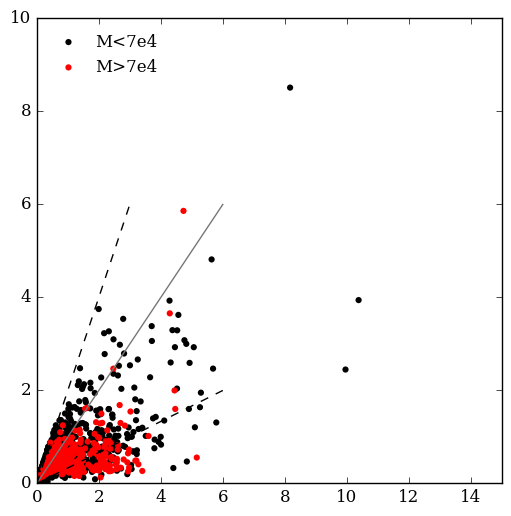

In [100]:
plt.scatter(tau_store[tau_store[:,1]<7e4,2], tau_store[tau_store[:,1]<7e4,3], c='k', label='M<7e4')
plt.scatter(tau_store[tau_store[:,1]>7e4,2], tau_store[tau_store[:,1]>7e4,3], c='r', label='M>7e4')
plt.plot([0,6],[0,6])
plt.plot([0,6],[0,2],c='k',ls='--')
plt.plot([0,3],[0,6],c='k',ls='--')
plt.xlim(0,15)
plt.ylim(0,10)
plt.legend()

In [101]:
selected = []
for id in tau_store[:,0]:
    selected.append(np.where(pid==id)[0][0])

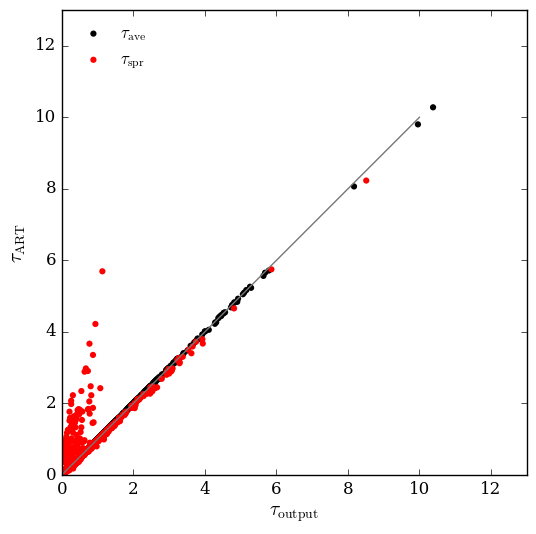

In [102]:
plt.scatter(tau_store[:,2], tave_ART[selected], c='k', label=r'$\tau_{\rm ave}$')
plt.scatter(tau_store[:,3], tspr_ART[selected], c='r', label=r'$\tau_{\rm spr}$')
plt.plot([0,10],[0,10])
plt.xlim(0,13)
plt.ylim(0,13)
plt.xlabel(r'$\tau_{\rm output}$')
plt.ylabel(r'$\tau_{\rm ART}$')
plt.legend()

In [103]:
selected = np.array(selected)

In [104]:
index_wrong_output = tspr_ART[selected]/tau_store[:,3]>1.5
index_wrong_ART = selected[index_wrong_output]

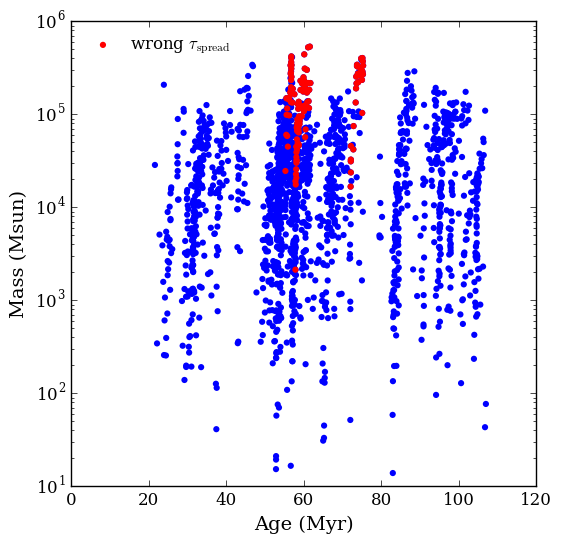

In [105]:
plt.scatter(age[selected],mass[selected])
plt.scatter(age[index_wrong_ART], mass[index_wrong_ART],c='r', label=r'wrong $\tau_{\rm spread}$')
plt.ylim(10,1e6)
plt.yscale('log')
plt.xlabel('Age (Myr)')
plt.ylabel('Mass (Msun)')
plt.legend()

In [110]:
np.sum(tau_store[:,1]==-1)

16

(100.0, 1000000.0)

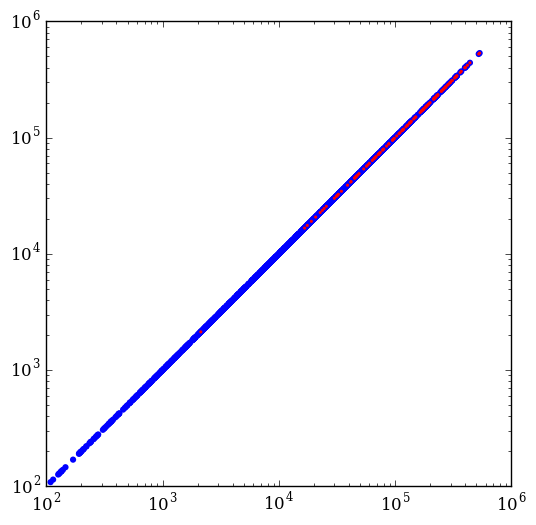

In [119]:
plt.scatter(tau_store[:,1], mass[selected])
plt.scatter(tau_store[index_wrong_output,1], mass[index_wrong_ART],c='r',s=5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e2,1e6)
plt.ylim(1e2,1e6)

In [63]:
i_wrong_output = np.arange(len(tau_store))[index_wrong_output]

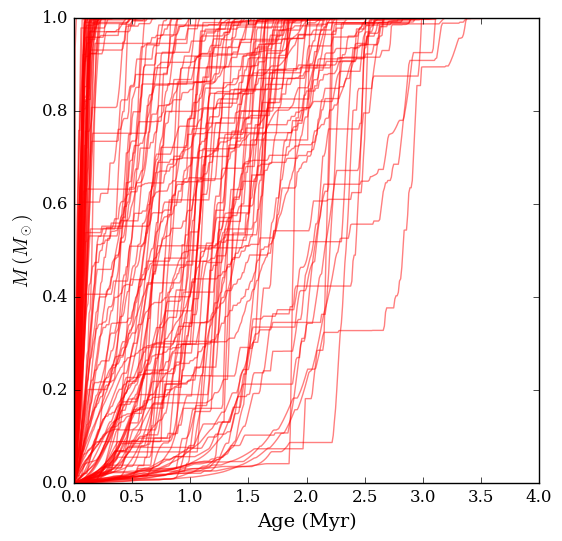

In [122]:
i = 0
for d in data_sorted:
    if np.max(d[:,5])<14.9:
        continue
    if np.min(d[:,5])>0.01:
        continue
    if i in i_wrong_output:
        plt.plot(d[:, 5], d[:,3]/d[:,3][-1], c='r', alpha=0.5)
    i = i+1
    
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0,4)
plt.ylim(0,1)
plt.xlabel('Age (Myr)')
plt.ylabel(r'$M\;(M_\odot)$')
#plt.savefig('cft_gap.png')

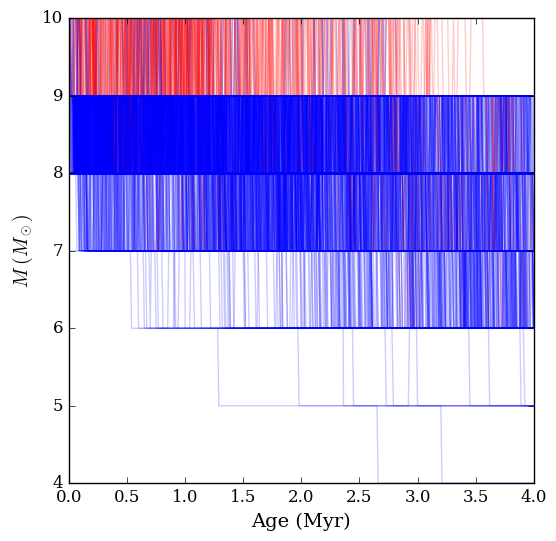

In [129]:
i = 0
for d in data_sorted:
    if np.max(d[:,5])<14.9:
        continue
    if np.min(d[:,5])>0.01:
        continue
    if i in i_wrong_output:
#         plt.plot(d[:, 5], d[:,3]/d[:,3][-1], c='r', alpha=0.5)
        plt.plot(d[:, 5], d[:,1], c='r', alpha=0.2)
    else:
        plt.plot(d[:, 5], d[:,1], c='b', alpha=0.2)
    i = i+1
    
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0,4)
#plt.ylim(0,1)
plt.xlabel('Age (Myr)')
plt.ylabel(r'$M\;(M_\odot)$')

The above plot helps me reveal the problem!!! The clusters with wrong tau_spread recorded in ART all start with 10th level and actively accrete material in this level. The cell size of this level at current redshift is about 4.3 pc. This means, at level 9, clusters accrete their masses with only the central cells, while, at level 10, accretion happened to all 27 cells. Since accretion at each neighboring cells calls function "grow_star_particle()" separately even at a given timestep. The calculation of tau_spread cumulates the sum of $\Sigma \frac{dm^2}{dt}$ for all 27 cells. This is wrong, since the accretion happens at the same time and the tau_spread should be $\frac{(\Sigma dm)^2}{dt}$!!!

## mass loss

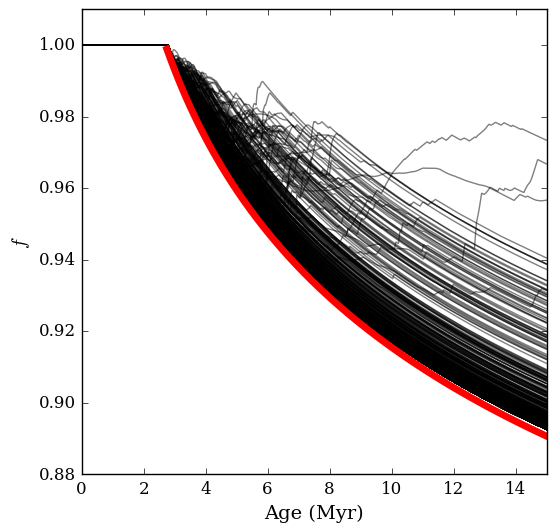

In [29]:
for d in data_sorted:
    if np.max(d[:,5])<14.5:
        continue
    if np.min(d[:,5])>0.02:
        continue
    #plt.scatter(d[:, 5], d[:,3]/d[:,3][-1],s=0.1)
    plt.plot(d[:,5], d[:,4]/d[:,3],c='k',alpha=0.5)
    
#plt.xscale('log')
#plt.yscale('log')

x = np.linspace(2.75,15,100)
plt.plot(x, 1-(-0.01033*(np.log10(x*1e6))**2+0.28751*(np.log10(x*1e6))-1.42188),c='r',lw=5)

plt.xlim(0,15)
plt.ylim(0.88,1.01)
plt.xlabel('Age (Myr)')
plt.ylabel(r'$f$')

## metal spread

In [130]:
Z_sun = 0.0199

/u/home/hliastro/yt-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide


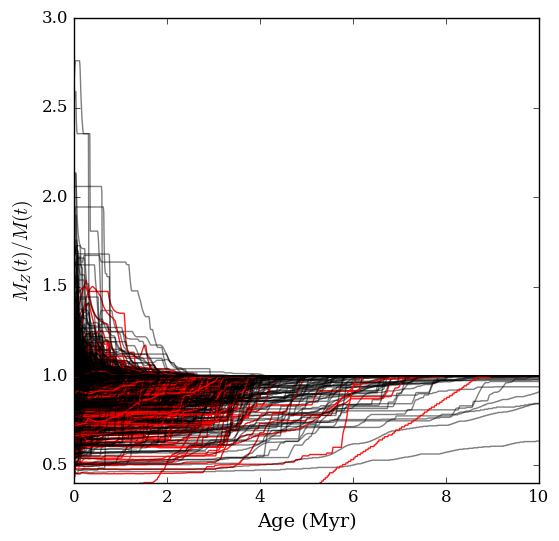

In [15]:
for d in data_sorted:
    if np.max(d[:,5])<14.9:
        continue
    if np.min(d[:,5])>0.01:
        continue
    #plt.scatter(d[:, 5], d[:,3]/d[:,3][-1],s=0.1)
    if d[:,3][-1]<7e4:
        plt.plot(d[:,5], d[:,-1]/d[-1,-1],c='k',alpha=0.5)
    else:
        plt.plot(d[:,5], d[:,-1]/d[-1,-1],c='r',alpha=0.9)
    
plt.xlim(0,10)
plt.ylim(0.4,3)
plt.xlabel('Age (Myr)')
plt.ylabel(r'$M_Z(t)/M(t)$')
plt.savefig('metal_evolution.png')

In [24]:
case = data_sorted[331]

In [28]:
mass_case = np.insert(case[:,3],0,0)
Z = np.insert(case[:,-1],0,0)
MZ = mass_case*Z

In [32]:
m_i = mass_case[1:]-mass_case[:-1]
mz_i = MZ[1:]-MZ[:-1]
Z_i = mz_i/m_i

/u/home/hliastro/yt-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


## test the Gaussianity of Z_i or lg(Z_i)

In [47]:
from scipy import stats

In [78]:
mu, std = norm.fit(Z_i[Z_i>0])
stats.kstest(Z_i[Z_i>0], 'norm', args=(mu, std))

/u/home/hliastro/yt-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/u/home/hliastro/yt-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


(0.21669715838612147, 1.6907806170696205e-06)

In [79]:
mu, std = norm.fit(np.log10(Z_i[Z_i>0]))
stats.kstest(np.log10(Z_i[Z_i>0]), 'norm', args=(mu, std))

/u/home/hliastro/yt-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/u/home/hliastro/yt-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


(0.16345921083493115, 0.00070767881123301457)

## lg(Z_i) is more Gaussian than Z_i, suggesting that Z_i follows log-normal distribution. Therefore, it is better to calculate the metallicity dispersion of Z_i in log space.

In [125]:
def metal_spread(mass, f_Z):
    Mz = mass*f_Z
    dm = mass[1:]-mass[:-1]
    dMz = Mz[1:]-Mz[:-1]
    i_selected = dm!=0.0
    
    Z_i = dMz[i_selected]/dm[i_selected]
    
    Z_ave = f_Z[-1]
    sigma2 = np.sum(dm[i_selected]*(Z_i-Z_ave)**2)/mass[-1]
    return np.sqrt(sigma2)

def metal_spread_log(mass, f_Z):
    Mz = mass*f_Z
    dm = mass[1:]-mass[:-1]
    dMz = Mz[1:]-Mz[:-1]
    i_selected = dm!=0.0
    
    logZ_i = np.log10(dMz[i_selected]/dm[i_selected])
    
    logZ_ave = np.average(logZ_i, weights=dm[i_selected])
    sigma2 = np.average((logZ_i-logZ_ave)**2, weights=dm[i_selected])
    return np.sqrt(sigma2)

In [122]:
aaa = data_sorted[350]
mass = aaa[:,3]
f_Z = aaa[:,-1]

In [142]:
metal_spread_log(mass, f_Z)

0.022319933219820957

In [126]:
metal_data = []
metal_log_data = []
for d in data_sorted:
    if np.max(d[:,5])<14.9:
        continue
    if np.min(d[:,5])>0.01:
        continue
    metal_data.append( [d[-1,-1], metal_spread(d[:,3], d[:,-1])])
    metal_log_data.append( [d[-1,-1], metal_spread_log(d[:,3], d[:,-1])])
    
metal_data = np.array(metal_data)
metal_log_data = np.array(metal_log_data)

/u/home/hliastro/yt-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in log10
/u/home/hliastro/yt-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10
/u/home/hliastro/yt-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in subtract


/u/home/hliastro/yt-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


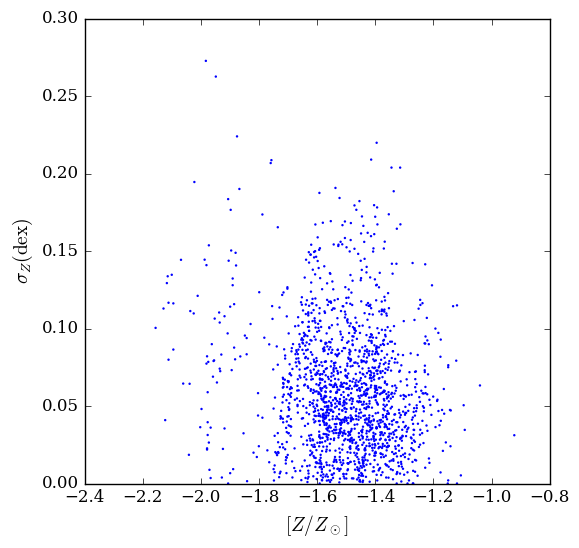

In [148]:
plt.scatter(np.log10(metal_log_data[:,0]/Z_sun), metal_log_data[:,1], s=3)
#plt.xlim(1e-5,0.04)
#plt.ylim(1e-6,1e-2)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$[Z/Z_\odot]$')
plt.ylabel(r'$\sigma_Z (\rm dex)$')
plt.ylim(0,0.3)
plt.legend()

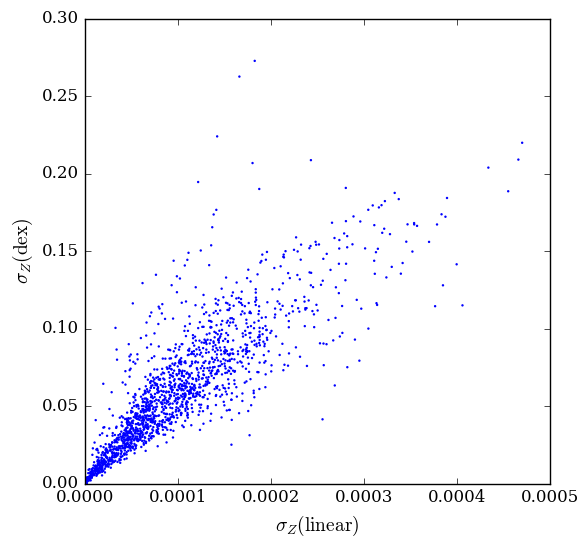

In [149]:
plt.scatter(metal_data[:,1], metal_log_data[:,1], s=3)
plt.xlim(0,0.0005)
plt.ylim(0,0.3)
plt.xlabel(r'$\sigma_Z (\rm linear)$')
plt.ylabel(r'$\sigma_Z (\rm dex)$')

## conversion from the mean $\mu$ and variance $\sigma$ of lognormal distribution to the true variance of the sample: $\sigma_{\rm sample} = (\exp{\sigma^2}-1)\exp{(2\mu+\sigma^2)}$

In [151]:
s2_log = metal_log_data[:,1]*metal_log_data[:,1]
sZ_linear = np.sqrt(np.exp(s2_log)-1.)*np.exp(2*np.log10(metal_log_data[:,0])+s2_log)

/u/home/hliastro/yt-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


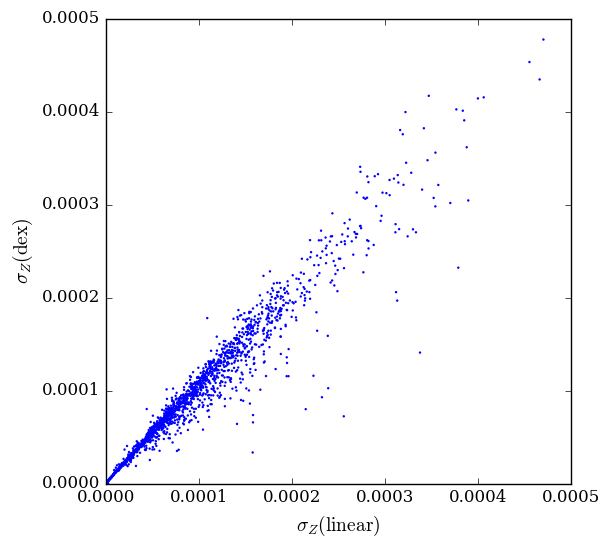

In [157]:
plt.scatter(metal_data[:,1], sZ_linear, s=3)
plt.xlim(0,0.0005)
plt.ylim(0,0.0005)
plt.xlabel(r'$\sigma_Z (\rm linear)$')
plt.ylabel(r'$\sigma_Z (\rm dex)$')

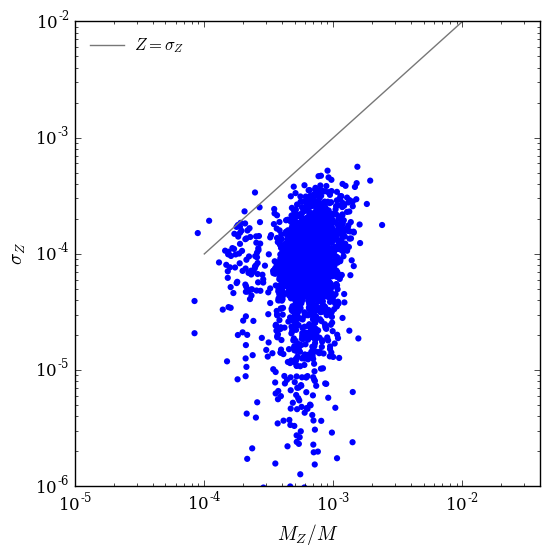

In [33]:
plt.scatter(metal_data[:,0], metal_data[:,1])
plt.plot([1e-4,1],[1e-4,1], label='$Z=\sigma_Z$')
plt.xlim(1e-5,0.04)
plt.ylim(1e-6,1e-2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$M_Z/M$')
plt.ylabel(r'$\sigma_Z$')
plt.legend()

In [180]:
def PLT_variance_2d(x, y, percentile=None, x_bins=None):
    """
    Split 2D scatter samples into different groups by x_bins.
    Return summary statistics of x and y in each bins.
    The summary statistics are listed below in order:
    mean, std, low/median/high quantiles
    """
    assert (len(x)==len(y)), "the length of x and y should be the same!"

    if percentile is None:
        percentile = 5
        
    # get rid of nan!
    index = (x>1e-50) & (x<1e50) & (y>1e-50) & (y<1e50)
    
    x = x[index]
    y = y[index]

    x_min = np.min(x)
    x_max = np.max(x)
    if x_bins is None:
        N_bins = np.sqrt(len(x))
        x_bins = np.linspace(x_min, x_max, N_bins)
    elif isinstance(x_bins, int):
        N_bins = x_bins
        x_bins = np.linspace(x_min, x_max, N_bins)

    data = []

    for i in range(len(x_bins)-1):
        index = (x>x_bins[i]) & (x<x_bins[i+1])
        if np.sum(index)<3:
            continue
        x_temp = x[index]
        y_temp = y[index]

        temp = [np.mean(x_temp), np.std(x_temp),
                np.percentile(x_temp, percentile), np.median(x_temp), np.percentile(x_temp, 100-percentile),
                np.mean(y_temp), np.std(y_temp),
                np.percentile(y_temp, percentile), np.median(y_temp), np.percentile(y_temp, 100-percentile)
               ]
        data.append(temp)

    return np.array(data)

In [199]:
data_percentile = PLT_variance_2d(np.log10(tau_store[:,1]), metal_log_data[:,1], percentile=25)

/u/home/hliastro/yt-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/u/home/hliastro/yt-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater
/u/home/hliastro/yt-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in less


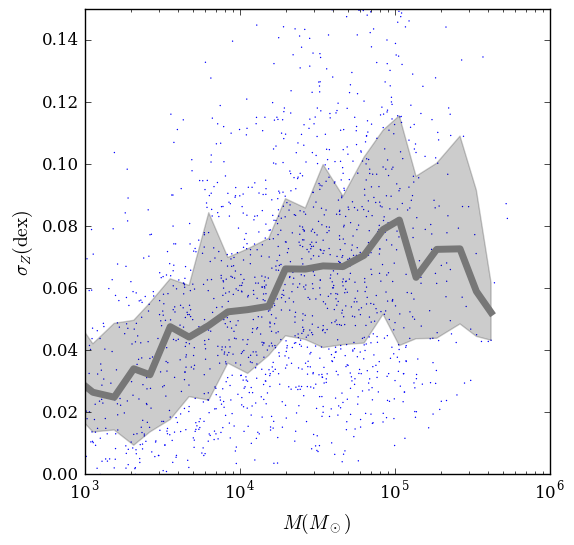

In [203]:
plt.scatter(tau_store[:,1], metal_log_data[:,1], s=1)
plt.plot(10**data_percentile[:,3], data_percentile[:,8],lw=5)
plt.fill_between(10**data_percentile[:,3], data_percentile[:,7], data_percentile[:,9], color='k', alpha=0.2)
plt.xscale('log')
plt.xlim(1e3,1e6)
plt.ylim(0,0.15)
plt.xlabel(r'$M (M_\odot)$')
plt.ylabel(r'$\sigma_Z (\rm dex)$')

In [35]:
MZ = ad[("STAR", "METALLICITY_SNII")]
MZZ = ad[('STAR', 'METAL_DISPERSION')]

In [36]:
std = np.sqrt(MZZ*data_ds.arr(1,"code_mass")/mass-MZ*MZ)

/u/home/hliastro/yt-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


In [42]:
np.sum(std>0)

5785

In [43]:
len(std)

5803

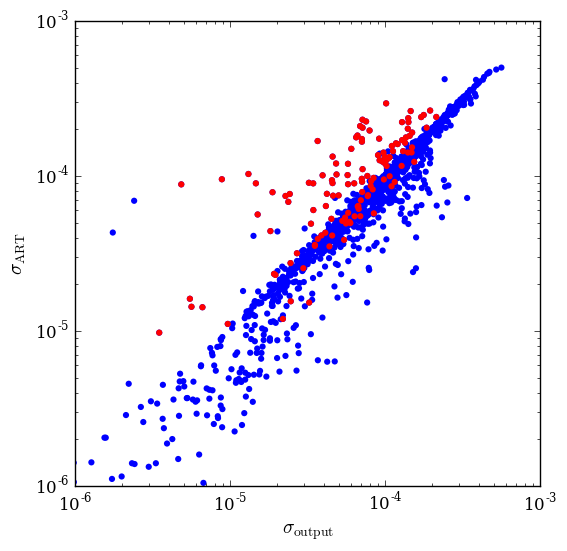

In [59]:
plt.scatter(metal_data[:,1], std[selected])
plt.scatter(metal_data[index_wrong_output,1], std[index_wrong_ART],c='r')
plt.xlim(1e-6,1e-3)
plt.ylim(1e-6,1e-3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\sigma_{\rm output}$')
plt.ylabel(r'$\sigma_{\rm ART}$')

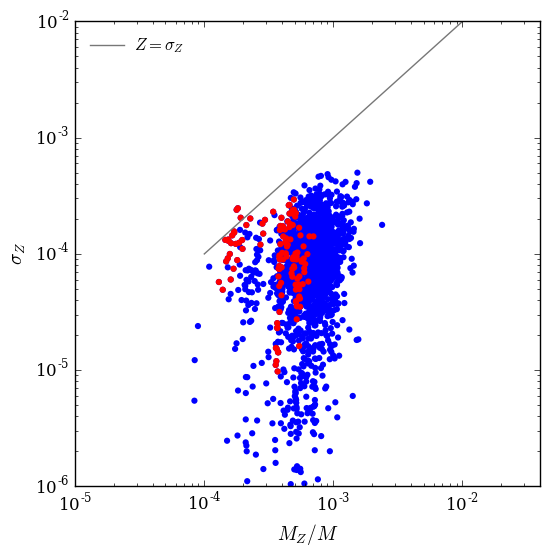

In [60]:
metal_data = np.array(metal_data)
#plt.scatter(MZ[selected], std[selected])
plt.scatter(MZ[selected], std[selected])
plt.scatter(MZ[index_wrong_ART], std[index_wrong_ART], c='r')
plt.plot([1e-4,1],[1e-4,1], label='$Z=\sigma_Z$')
plt.xlim(1e-5,0.04)
plt.ylim(1e-6,1e-2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$M_Z/M$')
plt.ylabel(r'$\sigma_Z$')
plt.legend()